Notebook by: Dimitris Kiaoulias

# Introduction:
This final project notebook will give students a perspective of how material that was covered in class relates to real work applications. MAE 6226 (Aero and hydrodynamics) supplied students with the tools to be able to simulate flow over an airfoil using a couple different methods such as, using a doublet superposed with a freestream in order to create a flow around a cylinder. However, in order to get lift out of the cylinder a vortex had to be added to the system and its velocity field has to be superposed to that of the doublet and then added to the freestream of the system. Now Joukowski's transformation is used in order to simulate the flow around an airfoil using this method. Another method is the vortex source panel method, which is what will be used to analyze the airfoils in this lesson. 

# Real world applications:
Airfoils can be found on a number of different systems in todays techological era. Engineers have found ways to utilize airfoils in applications such as stabalizing vehicles at high speeds. Airfoils primary task is usually to create some type of lifting force and in the realy world, vehicles such as helicopters and propeller driven aircrafts need to produce alot of it inorder to elevate. propellers are not the other source of lift in some applications, airplanes get their primary lift out of their airfoil shaped wings. With that said every aircraft has a different shaped airfoil for different reason, such as the need for more lift or less drag, but drag will not be analyzed in this notebook for this is a non viscous flow and if we look back to lesson 3 and 6 we learned that drag will be very close to zero from D'Alembert's paradox. In this notebook the airfoils that will be covered are the NACA 6412 for a plane propeller airfoil design, the Lockheed Martin c5a airfoil design, and the Northrop Grumman RQ-4 Global hawk wink airfoil design. 

# Now lets start coding :
First things first, import the libraries and import the airfoil geometrys from a directory csv or data file. 

In [1]:
import os
import numpy 
import math

from scipy import integrate, linalg
from matplotlib import pyplot


%matplotlib inline

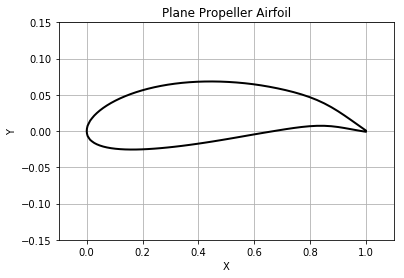

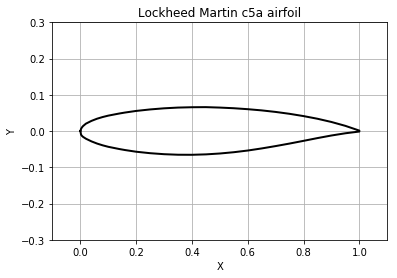

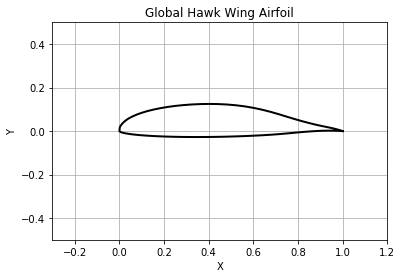

In [2]:

##### Plane Propeller airfoil #######
# Load geometry from data file
naca_filepath = os.path.join('data','NACA_6412_e853_propeller.csv')
with open (naca_filepath, 'r') as file_name:
    propeller_x, propeller_y = numpy.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)

# plot the propeller wing geometry 

pyplot.figure()
pyplot.grid()
pyplot.title('Plane Propeller Airfoil')
pyplot.xlabel('X')
pyplot.ylabel('Y')
pyplot.plot(propeller_x, propeller_y, color='k', linestyle='-', linewidth=2)
pyplot.xlim(-0.1,1.1)
pyplot.ylim(-0.15,0.15)


##### Lockheed Martin c5a airfoil blade #####
# Load geometry from data file
naca_filepath = os.path.join('data','c5a1.csv')
with open (naca_filepath, 'r') as file_name:
    rotorcraft_x, rotorcraft_y = numpy.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)

# plot the rotorcraft airfoil geometry 
pyplot.figure()
pyplot.grid()
pyplot.title('Lockheed Martin c5a airfoil')
pyplot.xlabel('X')
pyplot.ylabel('Y')
pyplot.plot(rotorcraft_x, rotorcraft_y, color='k', linestyle='-', linewidth=2)
pyplot.xlim(-0.1,1.1)
pyplot.ylim(-0.3,0.3)


##### Northrop RQ-4 Global Hawk wing airfoil #####
# Load geometry from data file
naca_filepath = os.path.join('data','Northrop_RQ-4_Global_Hawk.csv')
with open (naca_filepath, 'r') as file_name:
    RQ4_x, RQ4_y = numpy.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)

# plot the wing airfoil geometry 
pyplot.figure()
pyplot.grid()
pyplot.title('Global Hawk Wing Airfoil')
pyplot.xlabel('X')
pyplot.ylabel('Y')
pyplot.plot(RQ4_x, RQ4_y, color='k', linestyle='-', linewidth=2)
pyplot.xlim(-0.3,1.2)
pyplot.ylim(-0.5,0.5);

We define a class Panel that will store all information about one panel: start and end points, center point, length, orientation, source strength, tangential velocity and pressure coefficient. 

In [3]:
class Panel:
    def __init__(self, xa, ya, xb, yb):
        """
        Initializes the panel.
        
        Sets the end-points and calculates the center-point, length,
        and angle (with the x-axis) of the panel.
        Defines if the panel is located on the upper or lower surface of the geometry.
        Initializes the source-strength, tangential velocity, and pressure coefficient
        of the panel to zero.
        
        Parameters
        ---------_
        xa: float
            x-coordinate of the first end-point.
        ya: float
            y-coordinate of the first end-point.
        xb: float
            x-coordinate of the second end-point.
        yb: float
            y-coordinate of the second end-point.
            """
        self.xa, self.ya = xa, ya # panel starting point
        self.xb, self.yb = xb, yb # panel ending point
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2             # panel center
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2)     # panel length
        
        # orientation of panel (angle between x-axis and panels normal)
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        
        # panel location
        if self.beta <=numpy.pi:
            self.loc = 'upper' 
        else:
            self.loc = 'lower'
            
        self.sigma = 0.0   # source strength
        self.vt = 0.0      # tangential velocity
        self.cp = 0.0      # pressure coefficient

In [4]:
def define_panels(x, y, N=40):
    """
    Discretizes the geometry into panels using the 'cosine' method.
    
    Parameters
    ----------
    x: 1D array of floats
        x-coordinate of the points defining the geometry.
    y: 1D array of floats
        y-coordinate of the points defining the geometry.
    N: integer, optional
        Number of panels;
        default: 40.
    
    Returns
    -------
    panels: 1D Numpy array of Panel objects
        The discretization of the geometry into panels.
    """
   
    
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x[i], y[i], x[i + 1], y[i + 1])
    
    return panels

Here we use our panel definition function in order to define each airfoil geometry for each of our airfoil panels.

In [32]:

#####Plane Propeller#####
N1 = numpy.size(propeller_x)-1
panels = define_panels(propeller_x, propeller_y, N1)



#####Lockheed Martin c5a airfoil#####
N2 = numpy.size(rotorcraft_x)-1
#rotorcraft_x, rotorcraft_y = rotation(Pivot, Beta, rotorcraft_x, rotorcraft_y)
panels_r = define_panels(rotorcraft_x, rotorcraft_y, N2)



#####Northrop RQ-4 Global Hawk wing airfoil#####
N3 = numpy.size(RQ4_x)-1
panels_RQ4 = define_panels(RQ4_x, RQ4_y, N3)



61


Plot panel noes on each of the airfoil geometrys.

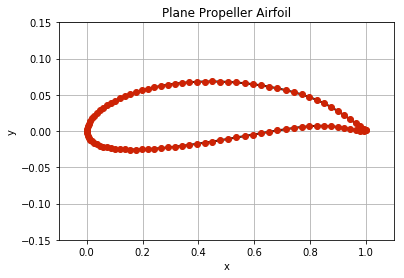

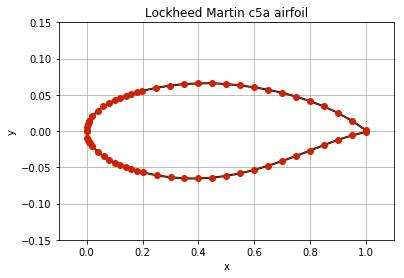

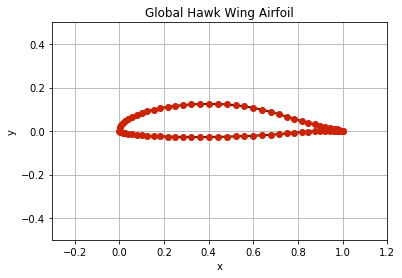

In [6]:
# plot the propeller wing geometry
pyplot.figure()
pyplot.grid()
pyplot.title('Plane Propeller Airfoil')
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.plot(propeller_x, propeller_y, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in panels], panels[0].xa),
            numpy.append([panel.ya for panel in panels], panels[0].ya),
            linestyle='-', linewidth=1,marker='o',markersize=6, color='#CD2305')
pyplot.xlim(-0.1,1.1)
pyplot.ylim(-0.15,0.15)


# Lockheed Martin c5a airfoil airfoil geometry
pyplot.figure()
pyplot.grid()
pyplot.title('Lockheed Martin c5a airfoil')
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.plot(rotorcraft_x, rotorcraft_y, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in panels_r], panels_r[0].xa),
            numpy.append([panel.ya for panel in panels_r], panels_r[0].ya),
            linestyle='-', linewidth=1,marker='o',markersize=6, color='#CD2305')
pyplot.xlim(-0.1,1.1)
pyplot.ylim(-0.15,0.15)


##### Northrop RQ-4 Global Hawk wing airfoil #####
pyplot.figure()
pyplot.grid()
pyplot.title('Global Hawk Wing Airfoil')
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.plot(RQ4_x, RQ4_y, color='k', linestyle='-', linewidth=2)
pyplot.plot(numpy.append([panel.xa for panel in panels_RQ4], panels_RQ4[0].xa),
            numpy.append([panel.ya for panel in panels_RQ4], panels_RQ4[0].ya),
            linestyle='-', linewidth=1,marker='o',markersize=6, color='#CD2305')
pyplot.xlim(-0.3,1.2)
pyplot.ylim(-0.5,0.5);

# Freestream conditions

The airfoils will be placed in a freestream with perameters $(U_\infty$,$\alpha)$, where U infinity and alpha are the velocity magnitude and angle of attack. 

In [7]:
class Freestream:
    def __init__(self, u_inf=1.0, alpha=0.0):
        self.u_inf = u_inf
        self.alpha = numpy.radians(alpha)

In [8]:
# define and creates the object freestream
u_inf = 1.0                            # freestream spee
alpha = 4.0                           # angle of attack (in degrees)
freestream = Freestream(u_inf, alpha)  # instantiation of the object freestream

alpha1=4.0
freestream1 = Freestream(u_inf,alpha1)



(The following computations can be seen in lesson 11 in more detail)

# Flow tangency baoundary condition

$$
\begin{align*}
\phi\left(x_{c_i},y_{c_i}\right) &amp;= V_\infty x_{c_i} \cos \alpha + V_\infty y_{c_i} \sin \alpha \\
&amp;+ \sum_{j=1}^N \frac{\sigma_j}{2\pi} \int_j \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) {\rm d}s_j \\
&amp;- \sum_{j=1}^N \frac{\gamma}{2\pi} \int_j \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right) {\rm d}s_j
\end{align*}
$$
The flow tangency boundary condition is applied at every panel center:
$$0 = \vec{V}\cdot\vec{n}_i = \frac{\partial}{\partial n_i} \left\{ \phi\left(x_{c_i},y_{c_i}\right) \right\}$$
i.e.
$$
\begin{align*}
0 &amp;= V_\infty \cos \left(\alpha-\beta_i\right) + \frac{\sigma_i}{2} \\
&amp;+ \sum_{j=1,j\neq i}^N \frac{\sigma_j}{2\pi} \int_j \frac{\partial}{\partial n_i} \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) {\rm d}s_j \\
&amp;- \sum_{j=1,j\neq i}^N \frac{\gamma}{2\pi} \int_j \frac{\partial}{\partial n_i} \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right) {\rm d}s_j
\end{align*}
$$
We already worked the first integral in the previous lesson:
$$\frac{\partial}{\partial n_i} \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) = \frac{\left(x_{c_i}-x_j\right)\frac{\partial x_{c_i}}{\partial n_i} + \left(y_{c_i}-y_j\right)\frac{\partial y_{c_i}}{\partial n_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2}$$
where $\frac{\partial x_{c_i}}{\partial n_i} = \cos \beta_i$ and $\frac{\partial y_{c_i}}{\partial n_i} = \sin \beta_i$, and
$$x_j(s_j) = x_{b_j} - s_j \sin \beta_j$$$$y_j(s_j) = y_{b_j} + s_j \cos \beta_j$$
We now need to derive the last integral of the boundary equation:
$$\frac{\partial}{\partial n_i} \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right)= \frac{\left(x_{c_i}-x_j\right)\frac{\partial y_{c_i}}{\partial n_i} - \left(y_{c_i}-y_j\right)\frac{\partial x_{c_i}}{\partial n_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2}$$
where $\frac{\partial x_{c_i}}{\partial n_i} = \cos \beta_i$ and $\frac{\partial y_{c_i}}{\partial n_i} = \sin \beta_i$.


# Enforcing the Kutta condition
To enforce the Kutta-condition, we state that the pressure coefficient on the first panel must be equal to that on the last panel:
$$C_{p_1} = C_{p_{N}}$$
Using the definition of the pressure coefficient $C_p = 1-\left(\frac{V}{U_\infty}\right)^2$, the Kutta-condition implies that the magnitude of the velocity at the first panel center must equal the magnitude of the last panel center:
$$V_1^2 = V_N^2$$
Since the flow tangency condition requires that $V_{n_1} = V_{n_N} = 0$, we end up with the following Kutta-condition:
$$V_{t_1} = - V_{t_N}$$
(the minus sign comes from the reference axis we chose for the normal and tangential vectors).
Let's derive the tangential velocity for every panel, since it will be useful to compute the pressure coefficient.
$$V_{t_i} = \frac{\partial}{\partial t_i} \left(\phi\left(x_{c_i},y_{c_i}\right)\right)$$
i.e.,
$$
\begin{align*}
V_{t_i} &amp;= V_\infty \sin \left(\alpha-\beta_i\right) \\
&amp;+ \sum_{j=1,j\neq i}^N \frac{\sigma_j}{2\pi} \int_j \frac{\partial}{\partial t_i} \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) {\rm d}s_j \\
&amp;- \sum_{j=1,j\neq i}^N \frac{\gamma}{2\pi} \int_j \frac{\partial}{\partial t_i} \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right) {\rm d}s_j \\
&amp;-\frac{\gamma}{2}
\end{align*}
$$
which gives
$$
\begin{align*}
V_{t_i} &amp;= V_\infty \sin \left(\alpha-\beta_i\right) \\
&amp;+ \sum_{j=1,j\neq i}^N \frac{\sigma_j}{2\pi} \int_j \frac{\left(x_{c_i}-x_j\right)\frac{\partial x_{c_i}}{\partial t_i} + \left(y_{c_i}-y_j\right)\frac{\partial y_{c_i}}{\partial t_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2} {\rm d}s_j \\
&amp;- \sum_{j=1,j\neq i}^N \frac{\gamma}{2\pi} \int_j \frac{\left(x_{c_i}-x_j\right)\frac{\partial y_{c_i}}{\partial t_i} - \left(y_{c_i}-y_j\right)\frac{\partial x_{c_i}}{\partial t_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2} {\rm d}s_j \\
&amp;-\frac{\gamma}{2}
\end{align*}
$$
where $\frac{\partial x_{c_i}}{\partial t_i} = -\sin \beta_i$ and $\frac{\partial y_{c_i}}{\partial t_i} = \cos \beta_i$.

# Building the linear system
Here, we build and solve the linear system of equations of the form
$$[A][\sigma,\gamma] = [b]$$





In [9]:
def integral(x, y, panel, dxdz, dydz):
    """
    Evaluates the contribution of a panel at one point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Source panel which contribution is evaluated.
    dxdz: float
        Derivative of x in the z-direction.
    dydz: float
        Derivative of y in the z-direction.
    
    Returns
    -------
    Integral over the panel of the influence at the given target point.
    """
    def integrand(s):
        return (((x - (panel.xa - numpy.sin(panel.beta) * s)) * dxdz +
                 (y - (panel.ya + numpy.cos(panel.beta) * s)) * dydz) /
                ((x - (panel.xa - numpy.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + numpy.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [10]:
def source_contribution_normal(panels):
    """
    Builds the source contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Source contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                    panel_j,
                                                    numpy.cos(panel_i.beta),
                                                    numpy.sin(panel_i.beta))
    return A

In [11]:
def vortex_contribution_normal(panels):
    """
    Builds the vortex contribution matrix for the normal velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    
    Returns
    -------
    A: 2D Numpy array of floats
        Vortex contribution matrix.
    """
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5 / numpy.pi * integral(panel_i.xc, panel_i.yc, 
                                                     panel_j,
                                                     numpy.sin(panel_i.beta),
                                                     -numpy.cos(panel_i.beta))
    return A

Each airfoil will need its own source matriz and vortex matix contributions. Not to worry, this is an easy task thanks to the functions we created above.

In [12]:
#####Propeller#####
A_source = source_contribution_normal(panels)
B_vortex = vortex_contribution_normal(panels)

####Lockheed Martin c5a airfoil#####
A_source_r = source_contribution_normal(panels_r)
B_vortex_r = vortex_contribution_normal(panels_r)

####Northrop RQ-4 Global Hawk#####
A_source_RQ4 = source_contribution_normal(panels_RQ4)
B_vortex_RQ4 = vortex_contribution_normal(panels_RQ4)


Now we show that:
the matrix resulting from the contribution of the vortices on the normal velocity, $B^n$, is exactly the matrix resulting from the contribution of the sources on the tangential velocity, $A^t$, i.e.
$$B^n_{ij}=A^t_{ij} \quad \forall (i, j) \in \{1, \cdots, N\}^2$$
the matrix resulting from the contribution of the vortices on the tangential velocity, $B^t$, is the opposite of the matrix resulting from the contribution of the sources on the normal velocity, $A^n$, i.e.
$$B^t_{ij}=-A^n_{ij} \quad \forall (i, j) \in \{1, \cdots, N\}^2$$
where the superscripts $n$ and $t$ denote the normal and tangential velocity components, respectively.

Kutta condition can now be cast in the following form
$$
\begin{bmatrix}
(A^t_{11}+A^t_{N1}) \\
\vdots \\ 
(A^t_{1N}+A^t_{NN}) \\
\left( \sum_{j=1}^N (B^t_{1j}+B^t_{Nj}) \right)
\end{bmatrix}^T
\begin{bmatrix}
\sigma_1 \\
\vdots \\
\sigma_N \\
\gamma
\end{bmatrix} = -(b^t_1+b^t_N)
$$
Let's define a function kutta_condition that does the job:

In [13]:
def kutta_condition(A_source, B_vortex):
    """
    Builds the Kutta condition array.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    b: 1D Numpy array of floats
        The left-hand side of the Kutta-condition equation.
    """
    b = numpy.empty(A_source.shape[0] + 1, dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    b[-1] = - numpy.sum(A_source[0, :] + A_source[-1, :])
    return b

In [14]:
def build_singularity_matrix(A_source, B_vortex):
    """
    Builds the left-hand side matrix of the system
    arising from source and vortex contributions.
    
    Parameters
    ----------
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    
    Returns
    -------
    A:  2D Numpy array of floats
        Matrix of the linear system.
    """
    A = numpy.empty((A_source.shape[0] + 1, A_source.shape[1] + 1), dtype=float)
    # source contribution matrix
    A[:-1, :-1] = A_source
    # vortex contribution array
    A[:-1, -1] = numpy.sum(B_vortex, axis=1)
    # Kutta condition array
    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A

In [15]:
def build_freestream_rhs(panels, freestream):
    """
    Builds the right-hand side of the system 
    arising from the freestream contribution.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    
    Returns
    -------
    b: 1D Numpy array of floats
        Freestream contribution on each panel and on the Kutta condition.
    """
    b = numpy.empty(panels.size + 1, dtype=float)
    # freestream contribution on each panel
    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    # freestream contribution on the Kutta condition
    b[-1] = -freestream.u_inf * (numpy.sin(freestream.alpha - panels[0].beta) +
                                 numpy.sin(freestream.alpha - panels[-1].beta) )
    return b

Here the A and b variables of the linear system
$[A][\sigma,\gamma] = [b]$ 
are created for each individual airfoil and in the cell directly after the strenghts (𝜎,𝛾) of each airfoil linear system are created.

In [16]:
#####Propeller#####
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(panels, freestream)

####Lockheed Martin c5a airfoil#####
A_r = build_singularity_matrix(A_source_r, B_vortex_r)
b_r = build_freestream_rhs(panels_r, freestream1)

#####Northrop RQ-4 Global Hawk#####
A_RQ4 = build_singularity_matrix(A_source_RQ4, B_vortex_RQ4)
b_RQ4 = build_freestream_rhs(panels_RQ4, freestream)



In [39]:
#####Propeller#####

# solve for singularity strengths for Propeller
strengths = numpy.linalg.solve(A, b)

# store source strength on each panel
for i , panel in enumerate(panels):
    panel.sigma = strengths[i]
    
# store circulation density
gamma = strengths[-1]


####Lockheed Martin c5a airfoil#####
strengths_r = numpy.linalg.solve(A_r, b_r)

# store source strength on each panel
for i , panel in enumerate(panels_r):
    panel.sigma = strengths_r[i]
    
# store circulation density
gamma_r = strengths_r[-1]


#####Northrop RQ-4 Global Hawk#####
strengths_RQ4 = numpy.linalg.solve(A_RQ4, b_RQ4)

# store source strength on each panel
for i , panel in enumerate(panels_RQ4):
    panel.sigma = strengths_RQ4[i]
    
# store circulation density
gamma_RQ4 = strengths_RQ4[-1]


In [18]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    """
    Computes the tangential surface velocity.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    gamma: float
        Circulation density.
    A_source: 2D Numpy array of floats
        Source contribution matrix for the normal velocity.
    B_vortex: 2D Numpy array of floats
        Vortex contribution matrix for the normal velocity.
    """
    A = numpy.empty((panels.size, panels.size + 1), dtype=float)
    # matrix of source contribution on tangential velocity
    # is the same than
    # matrix of vortex contribution on normal velocity
    A[:, :-1] = B_vortex
    # matrix of vortex contribution on tangential velocity
    # is the opposite of
    # matrix of source contribution on normal velocity
    A[:, -1] = -numpy.sum(A_source, axis=1)
    # freestream contribution
    b = freestream.u_inf * numpy.sin([freestream.alpha - panel.beta 
                                      for panel in panels])
    
    strengths = numpy.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = numpy.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [19]:
#####Propeller#####
# tangential velocity at each panel center.
compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex)

####Lockheed Martin c5a airfoil#####
# tangential velocity at each panel center.
compute_tangential_velocity(panels_r, freestream1, gamma_r, A_source_r, B_vortex_r)

#####Northrop RQ-4 Global Hawk#####
# tangential velocity at each panel center.
compute_tangential_velocity(panels_RQ4, freestream, gamma_RQ4, A_source_RQ4, B_vortex_RQ4)



# Surface pressure coefficient
In order to find the pressure coefficient we need the tangential velocity at each panel center computed above.


The pressure coefficient at the $i$-th panel center is:
$$C_{p_i} = 1 - \left(\frac{V_{t_i}}{U_\infty}\right)^2$$



In [20]:
def compute_pressure_coefficient(panels, freestream):
    """
    computes the surface coefficients.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2
        

In [21]:
# surface pressure coefficient for each airfoil

#####Propeller#####
compute_pressure_coefficient(panels, freestream)

####Lockheed Martin c5a airfoil#####
compute_pressure_coefficient(panels_r, freestream1)

#####Northrop RQ-4 Global Hawk#####
compute_pressure_coefficient(panels_RQ4, freestream)


# Plot the pressure distribution along the upper and lower airfoil surfaces.

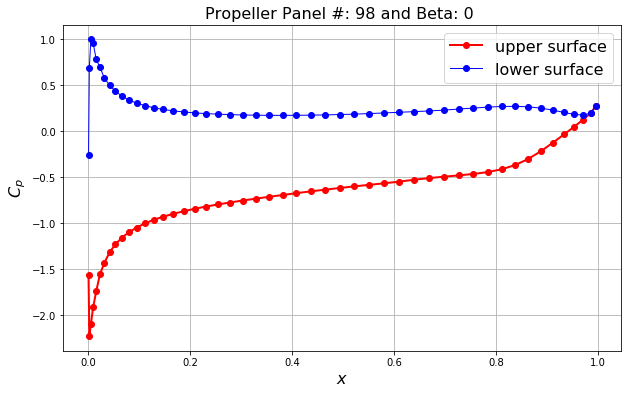

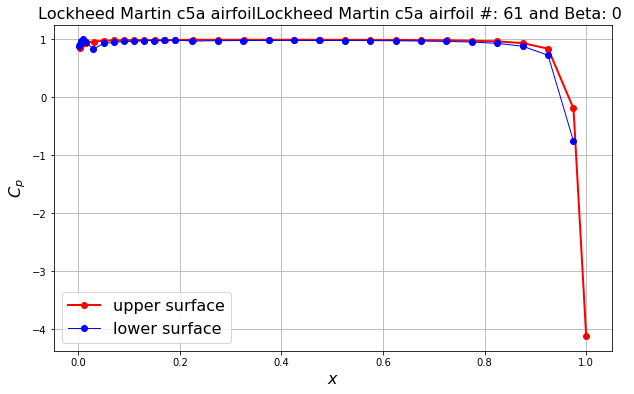

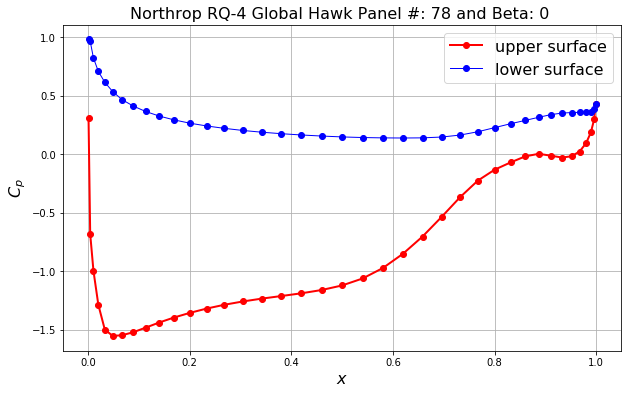

In [22]:
#####Propeller#####
# plot surface pressure coefficient
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'upper'],
            [panel.cp for panel in panels if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'lower'],
            [panel.cp for panel in panels if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(loc='best', prop={'size':16})
pyplot.autoscale(enable=True, axis='both', tight=None)
pyplot.title('Propeller Panel #: {} and Beta: 0 '.format(panels.size), fontsize=16);


####Lockheed Martin c5a airfoil#####
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels_r if panel.loc == 'upper'],
            [panel.cp for panel in panels_r if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panels_r if panel.loc == 'lower'],
            [panel.cp for panel in panels_r if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(loc='best', prop={'size':16})
pyplot.autoscale(enable=True, axis='both', tight=None)
pyplot.title('Lockheed Martin c5a airfoilLockheed Martin c5a airfoil #: {} and Beta: 0 '.format(panels_r.size), fontsize=16);


#####Northrop RQ-4 Global Hawk#####
pyplot.figure(figsize=(10, 6))
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels_RQ4 if panel.loc == 'upper'],
            [panel.cp for panel in panels_RQ4 if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panels_RQ4 if panel.loc == 'lower'],
            [panel.cp for panel in panels_RQ4 if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(loc='best', prop={'size':16})
pyplot.autoscale(enable=True, axis='both', tight=None)
pyplot.title('Northrop RQ-4 Global Hawk Panel #: {} and Beta: 0 '.format(panels_RQ4.size), fontsize=16);



Lift coefficient
The lift is given by the Kutta-Joukowski theorem, $L = \rho \Gamma U_\infty$, where $\rho$ is the fluid density. The total circulation $\Gamma$ is given by:
$$\Gamma = \sum_{i=1}^N \gamma l_i$$
Finally, the lift coefficient is given by:
$$C_l = \frac{\sum_{i=1}^N \gamma l_i}{\frac{1}{2}U_\infty c}$$

In [23]:
rho = 1.0

P_inf = 0

U_inf = 1.0

#####Propeller#####
for panel in panels:
    P = P_inf + 0.5 * rho* (U_inf**2 - panel.vt**2)

Lift_p, Drag_p = 0,0
Fx, Fy = 0,0
for panel in panels:
    Fx -= P * numpy.cos(panel.beta)*panel.length
    Fy -= P * numpy.sin(panel.beta)*panel.length
    Lift_p = -numpy.sin(alpha)*Fx + numpy.cos(alpha)*Fy
    Drag_p = numpy.cos(alpha)*Fx + numpy.sin(alpha)*Fy

print('Propeller airfoil Lift:',Lift_p)
print('Propeller airfoil Drag:',Drag_p)


####Lockheed Martin c5a airfoile#####
for panel in panels_r:
    P2 = P_inf + 0.5 * rho* (U_inf**2 - panel.vt**2)

Lift_r, Drag_r = 0,0
Fx2, Fy2 = 0,0
for panel in panels_r:
    Fx2 -= P2 * numpy.cos(panel.beta)*panel.length
    Fy2 -= P2 * numpy.sin(panel.beta)*panel.length
    Lift_r = -numpy.sin(alpha)*Fx2 + numpy.cos(alpha)*Fy2
    Drag_r = numpy.cos(alpha)*Fx2 + numpy.sin(alpha)*Fy2
print('Lockheed Martin c5a airfoil Lift:',Lift_r)
print('Lockheed Martin c5a airfoil Drag:',Drag_r)


#####Northrop RQ-4 Global Hawk#####
for panel in panels_RQ4:
    P3 = P_inf + 0.5 * rho* (U_inf**2 - panel.vt**2)

Lift_RQ4, Drag_RQ4 = 0,0
Fx3, Fy3 = 0,0
for panel in panels_RQ4:
    Fx3 -= P3 * numpy.cos(panel.beta)*panel.length
    Fy3 -= P3 * numpy.sin(panel.beta)*panel.length
    Lift_RQ4 = -numpy.sin(alpha)*Fx3 + numpy.cos(alpha)*Fy3
    Drag_RQ4 = numpy.cos(alpha)*Fx3 + numpy.sin(alpha)*Fy3
print('Northrop RQ-4 Global Hawk airfoil Lift:',Lift_RQ4)
print('Northrop RQ-4 Global Hawk airfoil Drag:',Drag_RQ4)

Propeller airfoil Lift: 0.00019123176954416064
Propeller airfoil Drag: -0.00016516518780525816
Lockheed Martin c5a airfoil Lift: 9.509798625887813e-18
Lockheed Martin c5a airfoil Drag: -3.543310262715617e-17
Northrop RQ-4 Global Hawk airfoil Lift: 1.5708754626185592e-17
Northrop RQ-4 Global Hawk airfoil Drag: -4.773524042385486e-17


# In this secion we will plot the Pressure distribustion on a 2D plan around each airfoil. 

First create a 2D mesh grid for each airfoil

In [24]:
N = 100
x_start1, x_end1 = -0.1, 1.1
y_start1, y_end1 = -0.5, 0.5
x_g = numpy.linspace(x_start1, x_end1,N)
y_g = numpy.linspace(y_start1, y_end1,N)
X, Y = numpy.meshgrid(x_g,y_g)

N = 50
x_start2, x_end2 = -0.3, 1.2
y_start2, y_end2 = -0.5, 0.5
x_r = numpy.linspace(x_start2, x_end2,N)
y_r = numpy.linspace(y_start2, y_end2,N)
X_r, Y_r = numpy.meshgrid(x_r,y_r)

x_start, x_end = -0.3,1.2
y_start, y_end = -0.5,0.5
x_RQ4 = numpy.linspace(x_start, x_end,N)
y_RQ4 = numpy.linspace(y_start, y_end,N)
X_RQ4, Y_RQ4 = numpy.meshgrid(x_RQ4,y_RQ4)

Knowing the strength of every panel, we find the $x$-component of the velocity by taking derivative of the velocity potential in the $x$-direction, and the $y$-component by taking derivative in the $y$-direction:
$$
u\left(x,y\right) = \frac{\partial}{\partial x}\left\lbrace \phi\left(x,y\right) \right\rbrace
$$$$
v\left(x,y\right) = \frac{\partial}{\partial y}\left\lbrace \phi\left(x,y\right) \right\rbrace
$$
Notice that here we call the function integral() with $1,0$ as the final arguments when calculating the derivatives in the $x$-direction, and $0,1$ for the derivatives in th $y$-direction.

In [25]:
def intregral_U_vp(X, Y, panel, dxdz, dydz):
    """
    Evaluates the contribution of a panel at one point.
    
    Parameters
    ----------
    x: float
        x-coordinate of the target point.
    y: float
        y-coordinate of the target point.
    panel: Panel object
        Source panel which contribution is evaluated.
    dxdz: float
        Derivative of x in the z-direction.
    dydz: float
        Derivative of y in the z-direction.
    
    Returns
    -------
    Integral over the panel of the influence at the given target point.
    """
    def integrand(s):
        return (((Y - (panel.ya + numpy.cos(panel.beta) * s)) * dxdz -
                 (X - (panel.xa - numpy.sin(panel.beta) * s)) * dydz) /
                ((X - (panel.xa - numpy.sin(panel.beta) * s))**2 +
                 (Y - (panel.ya + numpy.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

Here we will create a function that will compute the velocity field in a 2D grid around each airfoil. It is important to not that curently our integration is not vectorized and we will have to vectorize this integration in order to establish a velocity field on a 2D grid. As usual we ill also have to use superposition for the freestream, source velocity and vortex velocity. 

In [26]:
def get_velocity_field(panels, freestream, X, Y):
    """
    Computes the velocity field on a given 2D mesh.
    
    Parameters
    ---------
    panels: 1D array of Panel objects
        The source panels.
    freestream: Freestream object
        The freestream conditions.
    X: 2D Numpy array of floats
        x-coordinates of the mesh points.
    Y: 2D Numpy array of floats
        y-coordinate of the mesh points.
    
    Returns
    -------
    u: 2D Numpy array of floats
        x-component of the velocity vector field.
    v: 2D Numpy array of floats
        y-component of the velocity vector field.
    """
    # freestream contribution
    u = freestream.u_inf * math.cos(freestream.alpha) * numpy.ones_like(X, dtype=float)
    v = freestream.u_inf * math.sin(freestream.alpha) * numpy.ones_like(X, dtype=float)
    # add the contribution from each source (superposition powers!!!)
    vec_intregral = numpy.vectorize(integral)
    vec_intregral_U_vp = numpy.vectorize(intregral_U_vp)
    for panel in panels:
        u += (panel.sigma / (2.0 * math.pi) * vec_intregral(X, Y, panel, 1.0, 0.0) + gamma / (2.0 * math.pi) * vec_intregral_U_vp(X, Y, panel, 1.0, 0.0)) 
        v += (panel.sigma / (2.0 * math.pi) * vec_intregral(X, Y, panel, 0.0, 1.0) + gamma / (2.0 * math.pi) * vec_intregral_U_vp(X, Y, panel, 0.0, 1.0)) 
    
    return u, v

Calculate velocity field for each airfoil.

In [27]:
u, v = get_velocity_field(panels, freestream, X, Y)
u_r, v_r = get_velocity_field(panels_r, freestream1, X_r, Y_r)
u_RQ4, v_RQ4 = get_velocity_field(panels_RQ4, freestream, X_RQ4, Y_RQ4)

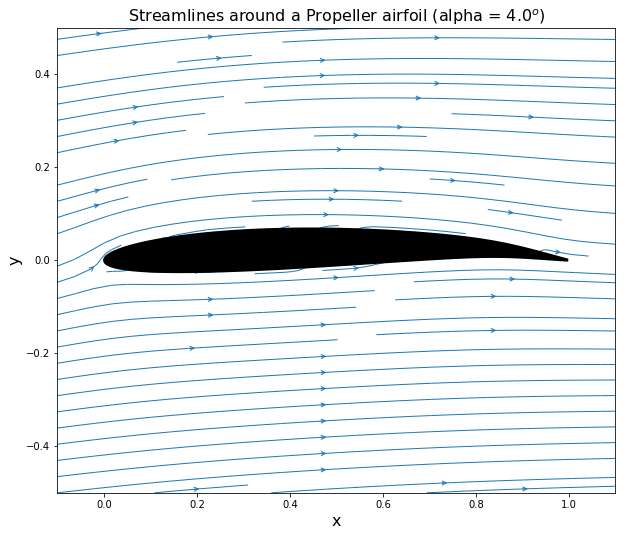

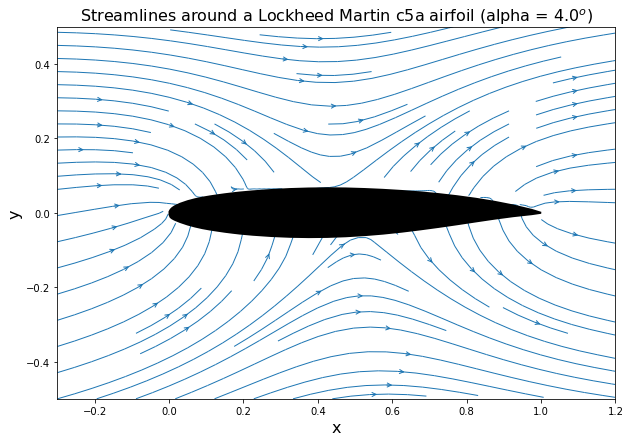

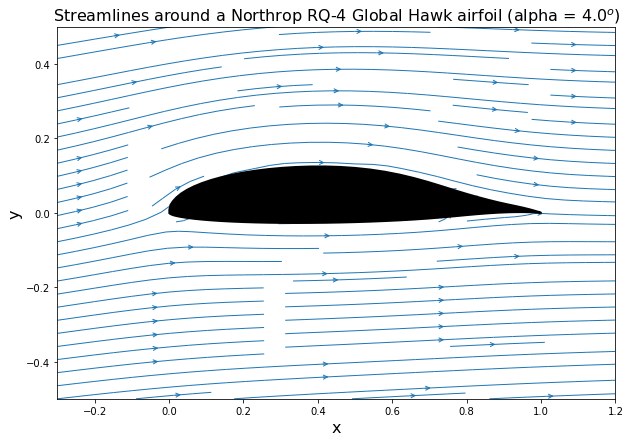

In [31]:
# Plot the velocity fields

##### propeller airfoil#####
width = 10
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.streamplot(X, Y, u, v,
                  density=1, linewidth=1, arrowsize=1, arrowstyle='->')
pyplot.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start1, x_end1)
pyplot.ylim(y_start1, y_end1)
pyplot.title('Streamlines around a Propeller airfoil (alpha = ${}^o$)'.format(alpha),
             fontsize=16);

#####Northrop RQ-4 Global Hawk#####
width = 10
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.streamplot(X_r, Y_r, u_r, v_r,
                  density=1, linewidth=1, arrowsize=1, arrowstyle='->')
pyplot.fill([panel.xc for panel in panels_r],
            [panel.yc for panel in panels_r],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start2, x_end2)
pyplot.ylim(y_start2, y_end2)
pyplot.title('Streamlines around a Lockheed Martin c5a airfoil (alpha = ${}^o$)'.format(alpha),
             fontsize=16);


#####Northrop RQ-4 Global Hawk#####
width = 10
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.streamplot(X_RQ4, Y_RQ4, u_RQ4, v_RQ4,
                  density=1, linewidth=1, arrowsize=1, arrowstyle='->')
pyplot.fill([panel.xc for panel in panels_RQ4],
            [panel.yc for panel in panels_RQ4],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.3 , 1.2)
pyplot.ylim(-0.5, 0.5)
pyplot.title('Streamlines around a Northrop RQ-4 Global Hawk airfoil (alpha = ${}^o$)'.format(alpha),
             fontsize=16);

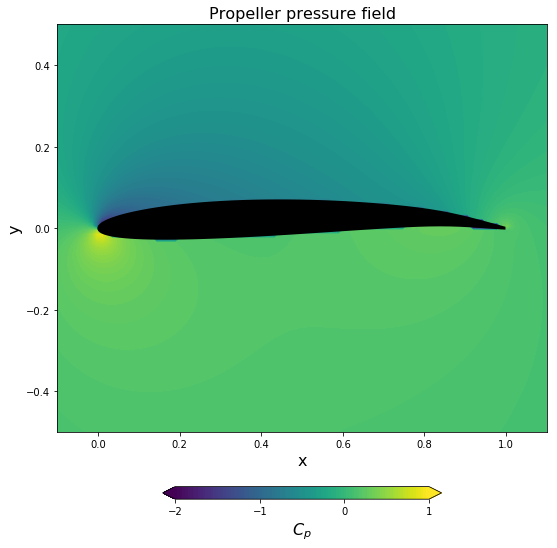

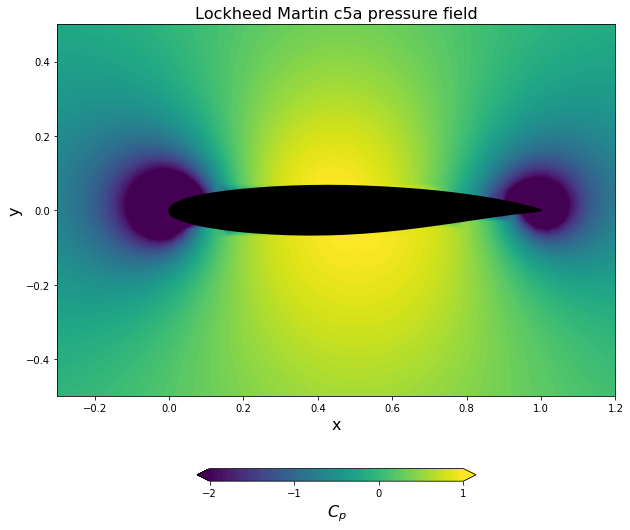

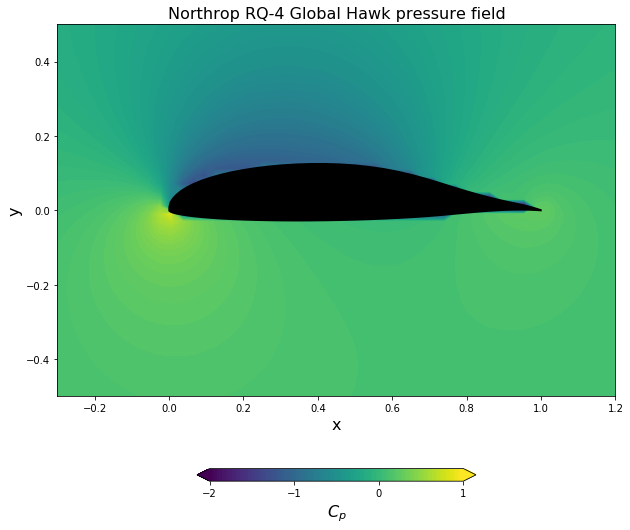

In [30]:
# Compute the pressure fields for each airfoil

####propeller airfoil#####
cp = 1.0 - (u**2 + v**2) / freestream.u_inf**2
####Lockheed Martin c5a airfoil#####
cp_r = 1.0 - (u_r**2 + v_r**2) / freestream1.u_inf**2
######compute pressure field for Northrop RQ-4 Global Hawk#####
cp_RQ4 = 1.0 - (u_RQ4**2 + v_RQ4**2) / freestream.u_inf**2



#####Propeller#####
# plot the pressure field
width = 10
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
contf = pyplot.contourf(X, Y, cp,
                        levels=numpy.linspace(-2.0, 1.0, 100), extend='both')
cbar = pyplot.colorbar(contf,
                       orientation='horizontal',
                       shrink=0.5, pad = 0.1,
                       ticks=[-2.0, -1.0, 0.0, 1.0])
cbar.set_label('$C_p$', fontsize=16)
pyplot.fill([panel.xc for panel in panels],
            [panel.yc for panel in panels],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start1, x_end1)
pyplot.ylim(y_start1, y_end1)
pyplot.title('Propeller pressure field', fontsize=16)


#####Lockheed Martin c5a airfoil#####
width = 10
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
contf = pyplot.contourf(X_r, Y_r, cp_r,
                        levels=numpy.linspace(-2.0, 1.0, 100), extend='both')
cbar = pyplot.colorbar(contf,
                       orientation='horizontal',
                       shrink=0.5, pad = 0.1,
                       ticks=[-2.0, -1.0, 0.0, 1.0])
cbar.set_label('$C_p$', fontsize=16)
pyplot.fill([panel.xc for panel in panels_r],
            [panel.yc for panel in panels_r],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(x_start2, x_end2)
pyplot.ylim(y_start2, y_end2)
pyplot.title('Lockheed Martin c5a pressure field', fontsize=16);


#####Northrop RQ-4 Global Hawk#####
width = 10
pyplot.figure(figsize=(width, width))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
contf = pyplot.contourf(X_RQ4, Y_RQ4, cp_RQ4,
                        levels=numpy.linspace(-2.0, 1.0, 100), extend='both')
cbar = pyplot.colorbar(contf,
                       orientation='horizontal',
                       shrink=0.5, pad = 0.1,
                       ticks=[-2.0, -1.0, 0.0, 1.0])
cbar.set_label('$C_p$', fontsize=16)
pyplot.fill([panel.xc for panel in panels_RQ4],
            [panel.yc for panel in panels_RQ4],
            color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.3,1.2)
pyplot.ylim(-0.5,0.5);
pyplot.title('Northrop RQ-4 Global Hawk pressure field', fontsize=16);

# XFLR 5


XLR5 is a program that conducts an analysis for any airfoil created or imported on or to the program. The program requires some parameters befor running the simulation such as angle of attack, renolds number, and if you want the flow to be viscous. 

The following is the analysis of the Northrup Grumman RQ-4 Global hawk wing airfoil. 

First lets look at the lift coefficient (Cl) Vs the length of the airfoil like we coded earlier in this notebook and see how they compare. 

![title](image/cpVsX_northrop.png)

You can see that the trends are very similar and what we can see here is that the bottom of the foil has more pressure than the top so we should expect lift at an attack angle of 4 degrees. 


Now lets see the same plot but with an attack angle of 0 degrees up to 10 degrees. 

![title](image/batch_analysis_northrup.jpg)

first thing to not is that the plot is not inverted the y axis is just different. The top is now negative and the bottom is positive.

What can we takeaway from this plot. Well we can see that as we increase the attack angle from 0 to 10 degrees the top surface of the airfoils Cp value decreases and the the bottom surfaces Cp value increases. This means that as the attack angle increases the Lifting force increases as well. 

XFLR5 includes a command where more than one analysis can be ran and shown at the same time. The next figure will show two plots. A Cl vs alpha plot, and a Cl/Cd vs alpha plot.

![title](image/northop_batchAnalysis.png)

The lime green line represents a non viscous flow
The purple line represents a viscous flow

These charts are useful because they can show the designer where the peak performace for the angle of attack is for each chart. However for the viscous flow a higher alpha should be analzed in order to find the peak. 

The same analysis was done for the propeller and similar results were outputed.


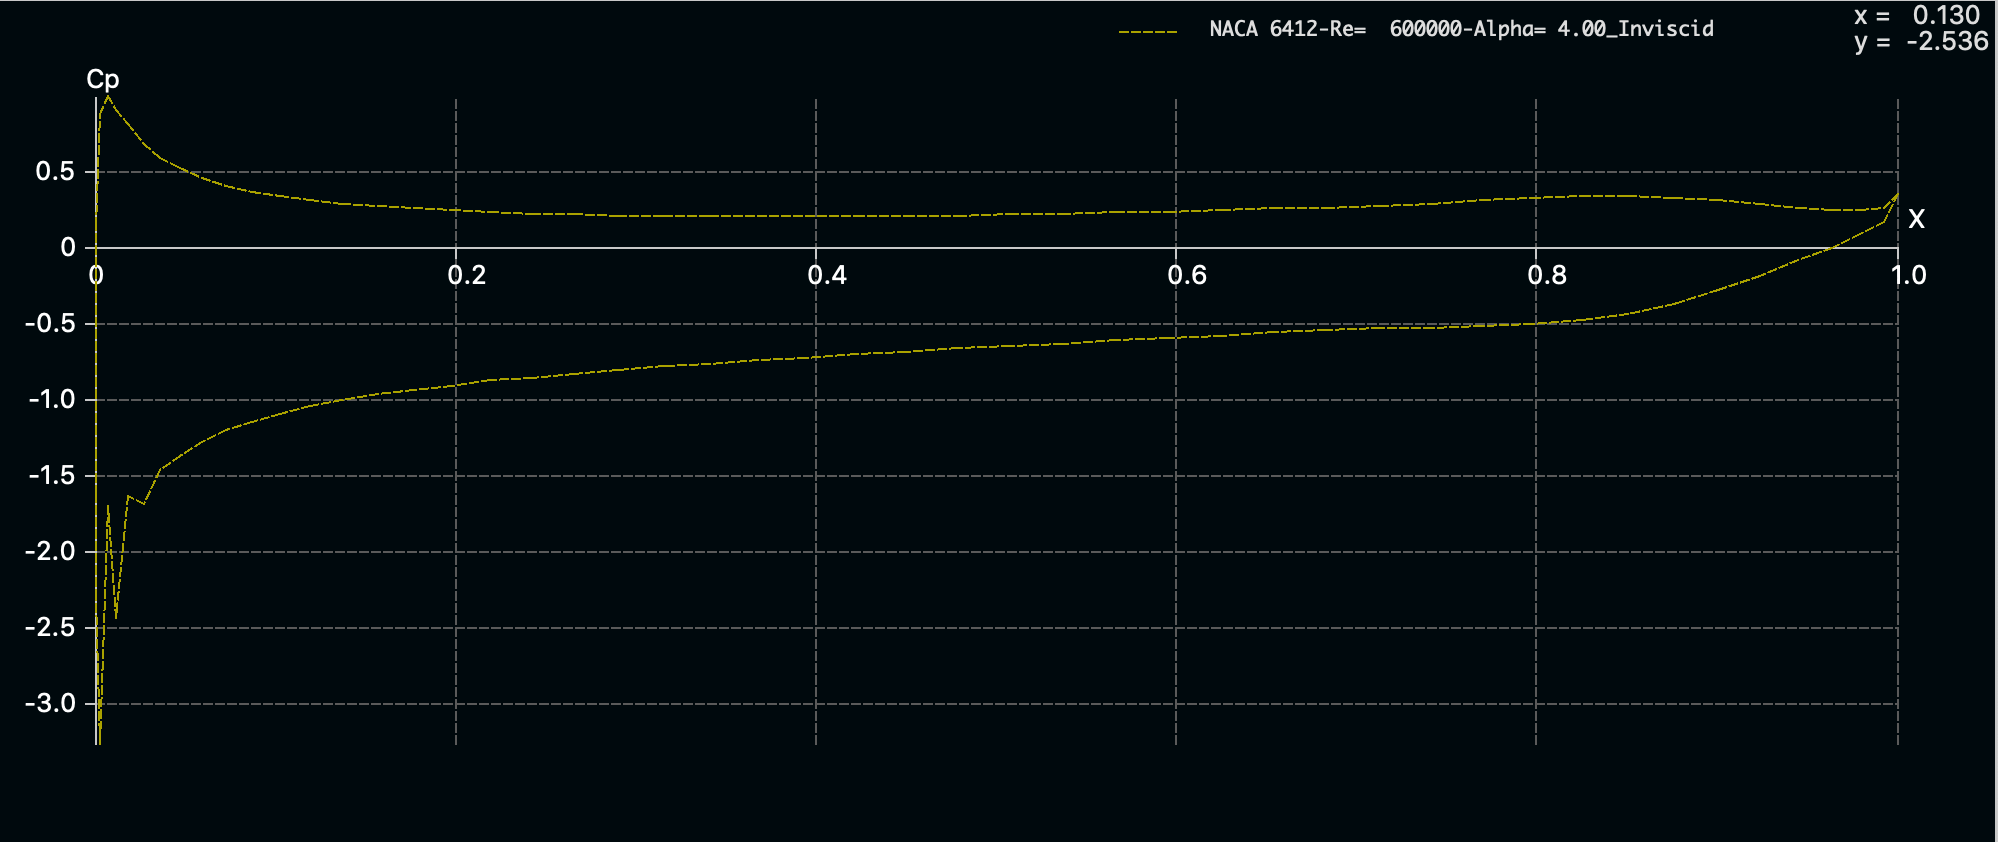
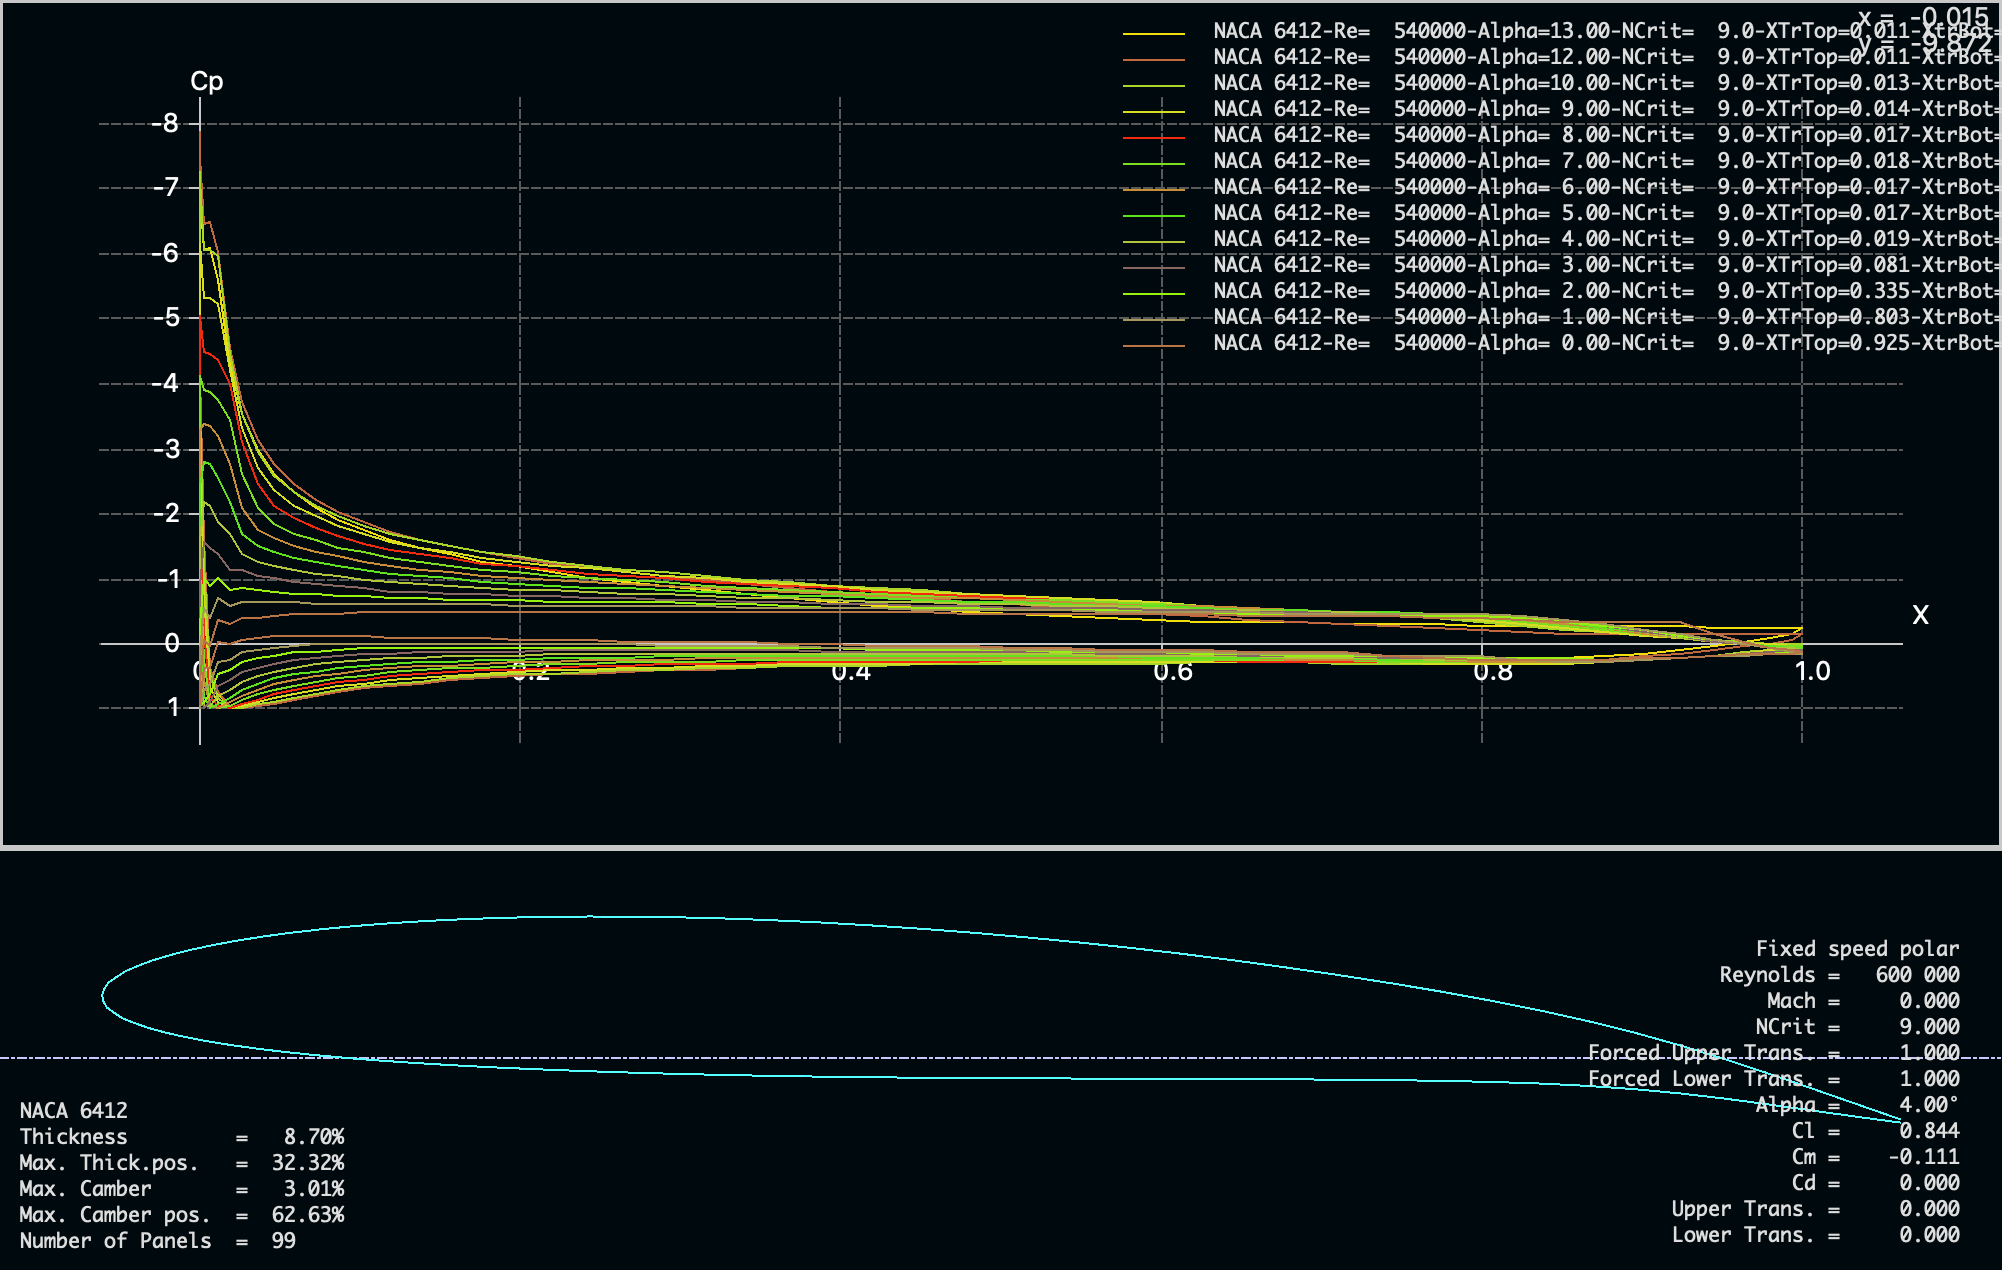
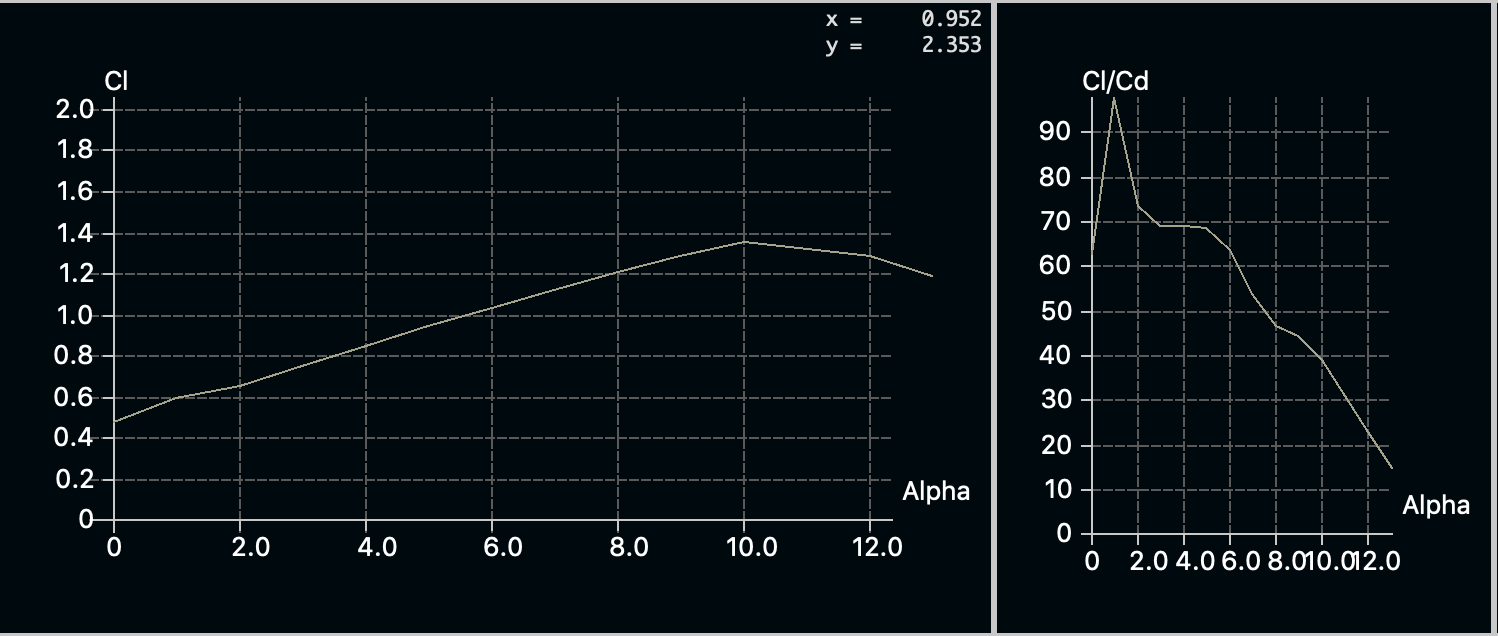

# references

L.A. Barba, Olivier Mesnard, Pi-Yueh Chuang, Natalia Clementi. Vortex-source panel method, source panel method, and doublet. Aerodynamics in python, Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c)2015 L.A. Barba, Olivier Mesnard, Pi-Yueh Chuang, Natalia Clementi.